#### Перед вами данные взаимодействий с рекламными объявлениями на некоторой площадке за 6 дней. И таблица с характеристиками рекламных клиентов (тех, кто разместил эти объявления).

Задачи:

- Разберемся с распределением количества показов и кликов. Посчитайте среднее количество показов и среднее количество кликов на объявления за весь период (округлите до целых).

- Нарисуйте график распределения показов на объявление за весь период.

- Давайте посчитаем скользящее среднее показов с окном 2. Какое значение скользящего среднего получим за 6 апреля 2019 года (ответ округлите до целых)?

- Скользящее среднее часто используется для поиска аномалий в данных. Давайте попробуем нанести на один график значения арифметического среднего по дням и скользящего среднего количества показов. В какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним? Дни, в которых скользящее среднее равно NaN, не учитываем.

- Напишите функцию, которая найдет проблемное объявление (с наибольшим/наименьшим количеством показов) в день, в который была замечена самая большая по модулю аномалия.

- Теперь подгрузим данные по рекламным клиентам и найдем среднее количество дней от даты создания рекламного клиента и первым запуском рекламного объявления этим клиентом.

- Вычислите конверсию из создания рекламного клиента в запуск первой рекламы в течение не более 365 дней. Ответ дайте в процентах и округлите до сотых. (Фильтровать нужно по значению в формате pd.Timedelta(365, unit='d'))

- Давайте разобъем наших клиентов по промежуткам от создания до запуска рекламного объявления, равным 30. Определите, сколько уникальных клиентов запустили свое первое объявление в первый месяц своего существования (от 0 до 30 дней). Список промежутков для метода pd.cut – [0, 30, 90, 180, 365]

- А теперь – выведем на интерактивный график эти категории с количеством уникальных клиентов в них.

Описание данных

ads_data.csv – данные взаимодействий с рекламными объявлениями

- date – дата
- time – время
- event – действие (просмотр/клик)
- platform – платформа
- ad_id – id объявления
- client_union_id – id рекламного кабинета
- campaign_union_id – id рекламной кампании
- ad_cost_type – тип оплаты
- ad_cost – цена
- has_video – есть ли видео
- target_audience_count – размер аудитории

ads_clients_data.csv – характеристики рекламных клиентов

- date – дата
- client_union_id – id рекламного кабинета
- community_id – id сообщества
- create_date – дата создания рекламного клиента

In [45]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [46]:
sns.set( font_scale = 2,
       style = 'whitegrid',
       rc = {'figure.figsize':(20,7)})

In [13]:
ads = pd.read_csv('C:/Users/79295/Desktop/GITHUB/Analytical-practice/datasets/ads_data.zip')
ads_client = pd.read_csv('C:/Users/79295/Desktop/GITHUB/Analytical-practice/datasets/ads_clients_data.zip')

In [14]:
ads.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [15]:
ads_client.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [21]:
ads.date = pd.to_datetime(ads.date)
ads.time = pd.to_datetime(ads.time)
ads_client.date = pd.to_datetime(ads_client.date)
ads_client.create_date = pd.to_datetime(ads_client.create_date)

In [22]:
ads.dtypes

date                     datetime64[ns]
time                     datetime64[ns]
event                            object
platform                         object
ad_id                             int64
client_union_id                   int64
campaign_union_id                 int64
ad_cost_type                     object
ad_cost                         float64
has_video                         int64
target_audience_count             int64
dtype: object

In [23]:
ads_client.dtypes

date               datetime64[ns]
client_union_id             int64
community_id                int64
create_date        datetime64[ns]
dtype: object

In [24]:
# Разберемся с распределением количества показов и кликов. Посчитайте среднее количество показов и 
# среднее количество кликов на объявления за весь период (округлите до целых).

In [26]:
ads.event.value_counts()

view     890822
click    109178
Name: event, dtype: int64

In [70]:
actions_per_ad = ads.groupby(['ad_id','event']) \
    .agg({"platform":"count"}) \
    .reset_index() \
    .rename(columns={"platform":"total_actions"}) \
    .pivot(index = 'ad_id', values = 'total_actions', columns = 'event') \
    .round() \
    .fillna(0).reset_index()
actions_per_ad

event,ad_id,click,view
0,2,1.0,101.0
1,3,3.0,184.0
2,1902,1.0,41.0
3,2064,0.0,35.0
4,2132,1.0,58.0
...,...,...,...
960,122004,4.0,100.0
961,122013,0.0,156.0
962,122023,0.0,68.0
963,122031,1.0,138.0


In [71]:
actions_per_ad.click.mean()


113.1378238341969

In [60]:
actions_per_ad.view.mean()

923.1316062176165

In [51]:
# Нарисуйте график распределения показов на объявление за весь период

In [99]:
log_views = np.log(ads[ads.event =="view"].ad_id.value_counts())
log_views

112583    12.770824
107729    12.125925
107837    10.858922
28142     10.092122
45008      9.886748
            ...    
110591     2.564949
45969      2.564949
112872     2.397895
42507      2.397895
98274      2.302585
Name: ad_id, Length: 956, dtype: float64

<AxesSubplot:xlabel='ad_id', ylabel='Count'>

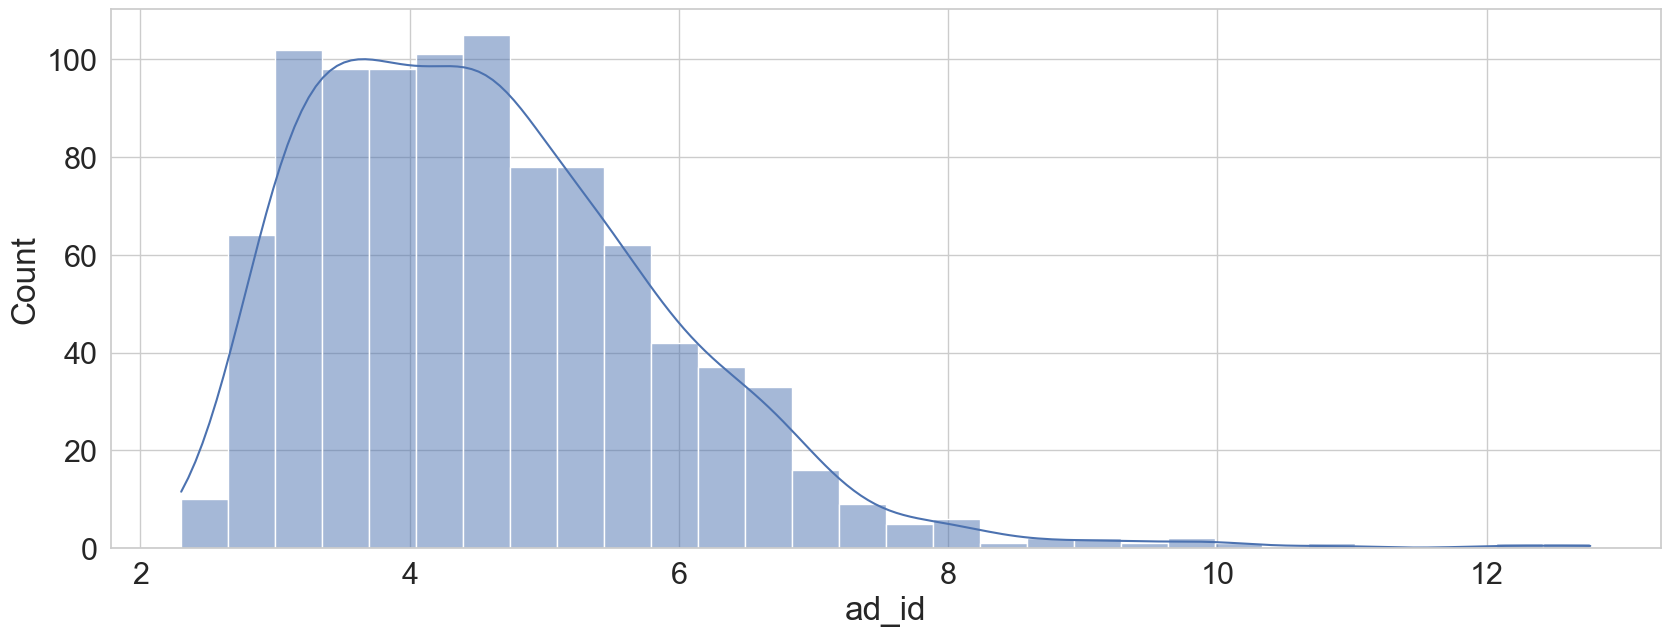

In [100]:
sns.histplot(data = log_views, kde=True)

In [101]:
# Теперь нужно найти среднее количество показов на 1 объявление (ad_id) по дням, не учитывая объявления, 
# у которых не было показов (обычное среднее). 
# После этого посчитайте скользящее среднее по полученному результату с окном в 2 элемента.

#Вопрос: Какое значение скользящего среднего получим за 6 апреля 2019 года? Округлите ответ до целого числа.

# Могут пригодиться: pivot(), скользящее среднее

In [122]:
views_per_day = ads[ads.event == 'view'].groupby(['date','ad_id'],as_index=False) \
    .agg({"event":"count"}) \
    .pivot(index='ad_id', columns = 'date', values = 'event')
views_per_day

date,2019-04-01,2019-04-02,2019-04-03,2019-04-04,2019-04-05,2019-04-06
ad_id,,,,,,
2,83.0,18.0,NaN,NaN,NaN,NaN
3,158.0,26.0,NaN,NaN,NaN,NaN
1902,NaN,NaN,34.0,7.0,NaN,NaN
2064,NaN,28.0,7.0,NaN,NaN,NaN
2132,NaN,NaN,25.0,27.0,6.0,NaN
...,...,...,...,...,...,...
122004,85.0,15.0,NaN,NaN,NaN,NaN
122013,NaN,NaN,NaN,134.0,22.0,NaN
122023,NaN,NaN,NaN,53.0,15.0,NaN


In [129]:
mean_views = views_per_day.mean()
mean_views

date
2019-04-01    154.482270
2019-04-02    137.786982
2019-04-03    163.952778
2019-04-04    675.901720
2019-04-05    919.109677
2019-04-06    277.122727
dtype: float64

In [132]:
rolling_views = mean_values.rolling(2).mean()
rolling_views

date
2019-04-01           NaN
2019-04-02    146.134626
2019-04-03    150.869880
2019-04-04    419.927249
2019-04-05    797.505699
2019-04-06    598.116202
dtype: float64

In [136]:
rolling_views["2019-04-06"].round()

598.0

In [137]:
# Скользящее среднее часто используется для поиска аномалий в данных. 
# Давайте попробуем нанести на один график значения просто среднего количества показов по дням 
# и скользящего среднего на основе этих данных (которое мы получили в прошлом задании).

# Посчитайте, в какой день наблюдается наибольшая разница по модулю между арифметическим средним и скользящим средним?
# Дни, в которых скользящее среднее равно NaN, не учитываем. Запишите ответ в формате yyyy-MM-dd

#Пример ответа: 2020-12-31

#Могут пригодиться:sns.lineplot(), скользящее среднее, значение по модулю